# 0.0. Imports

In [425]:
import json
import math
# import pylab 
import random
import pickle
import requests
import result
import datetime
import warnings
warnings.filterwarnings( 'ignore')
import inflection
import numpy as np
import pandas as pd 
import seaborn as sns
import xgboost as xgb
                

from scipy                 import stats  as ss
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression
from sklearn.linear_model  import Lasso
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler
from matplotlib.ticker     import PercentFormatter


from flask                         import Flask, request, Response
from boruta                        import BorutaPy
from matplotlib                    import pyplot as plt
from matplotlib                    import gridspec
from IPython.display               import Image
from IPython.core.display          import HTML
from IPython.core.interactiveshell import InteractiveShell

%pylab inline
%matplotlib inline


plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 24

display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )

sns.set();

Populating the interactive namespace from numpy and matplotlib


## 0.1 Helper Functions

## 0.2. Loading Data

In [2]:
df_raw = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

## Attribute Information:

Thirteen (13) clinical features:

- **age**: age of the patient (years)
- **anaemia**: decrease of red blood cells or hemoglobin (boolean)
- **high blood pressure**: if the patient has hypertension (boolean)
- **creatinine phosphokinase (CPK)**: level of the CPK enzyme in the blood (mcg/L)
- **diabetes**: if the patient has diabetes (boolean)
- **ejection fraction**: percentage of blood leaving the heart at each contraction (percentage)
- **platelets**: platelets in the blood (kiloplatelets/mL)
- **sex**: woman or man (binary)
- **serum creatinine**: level of serum creatinine in the blood (mg/dL)
- **serum sodium**: level of serum sodium in the blood (mEq/L)
- **smoking**: if the patient smokes or not (boolean)
- **time**: follow-up period (days)
- **[target] death event**: if the patient deceased during the follow-up period (boolean)

In [3]:
df_raw.sample(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
132,46.0,0,719,0,40,1,263358.03,1.18,137,0,0,107,0
90,70.0,0,66,1,45,0,249000.00,0.80,136,1,1,80,0
42,70.0,0,571,1,45,1,185000.00,1.20,139,1,1,33,1
36,90.0,1,60,1,50,0,226000.00,1.00,134,1,0,30,1
147,64.0,0,1610,0,60,0,242000.00,1.00,137,1,0,113,0


# 1.0. STEP 01 - DESCRIPTION OF DATA

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
# rename columns so they are all tiny
cols_old = ['age', 'anaemia','creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine','serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [6]:
df1.sample(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
155,60.0,1,231,1,25,0,194000.0,1.7,140,1,0,120,0
41,50.0,0,124,1,30,1,153000.0,1.2,136,0,1,32,1
154,65.0,1,335,0,35,1,235000.0,0.8,136,0,0,120,0
217,54.0,1,427,0,70,1,151000.0,9.0,137,0,0,196,1
233,53.0,1,707,0,38,0,330000.0,1.4,137,1,1,209,0


## 1.2. Data Dimensions

In [7]:
print('Number of Rows : {}'.format(df1.shape[0]))
print('Number of Cols : {}'.format(df1.shape[1]))

Number of Rows : 299
Number of Cols : 13


## 1.3. Data Types

In [8]:
df1.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
death_event                   int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
death_event                 0
dtype: int64

## 1.5. Fillout NA

## 1.6. Change Data Types

## 1.7. Descriptive Statistical

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

### 1.7.1 Numerical Attributes

In [421]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes','min','max','range','mean','median','std','skew','kurtosis'] )
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,40.0,95.0,-40.0,60.833893,60.0,11.874901,0.423062,-0.184871
1,anaemia,0.0,1.0,0.0,0.431438,0.0,0.495277,0.278261,-1.935563
2,creatinine_phosphokinase,23.0,7861.0,-23.0,581.839465,250.0,968.663967,4.463110,25.149046
3,diabetes,0.0,1.0,0.0,0.418060,0.0,0.493240,0.333929,-1.901254
4,ejection_fraction,14.0,80.0,-14.0,38.083612,38.0,11.815033,0.555383,0.041409
5,high_blood_pressure,0.0,1.0,0.0,0.351171,0.0,0.477336,0.626732,-1.618076
6,platelets,25100.0,850000.0,-25100.0,263358.029264,262000.0,97640.547655,1.462321,6.209255
7,serum_creatinine,0.5,9.4,-0.5,1.393880,1.1,1.032779,4.455996,25.828239
8,serum_sodium,113.0,148.0,-113.0,136.625418,137.0,4.405092,-1.048136,4.119712
9,sex,0.0,1.0,0.0,0.648829,1.0,0.477336,-0.626732,-1.618076


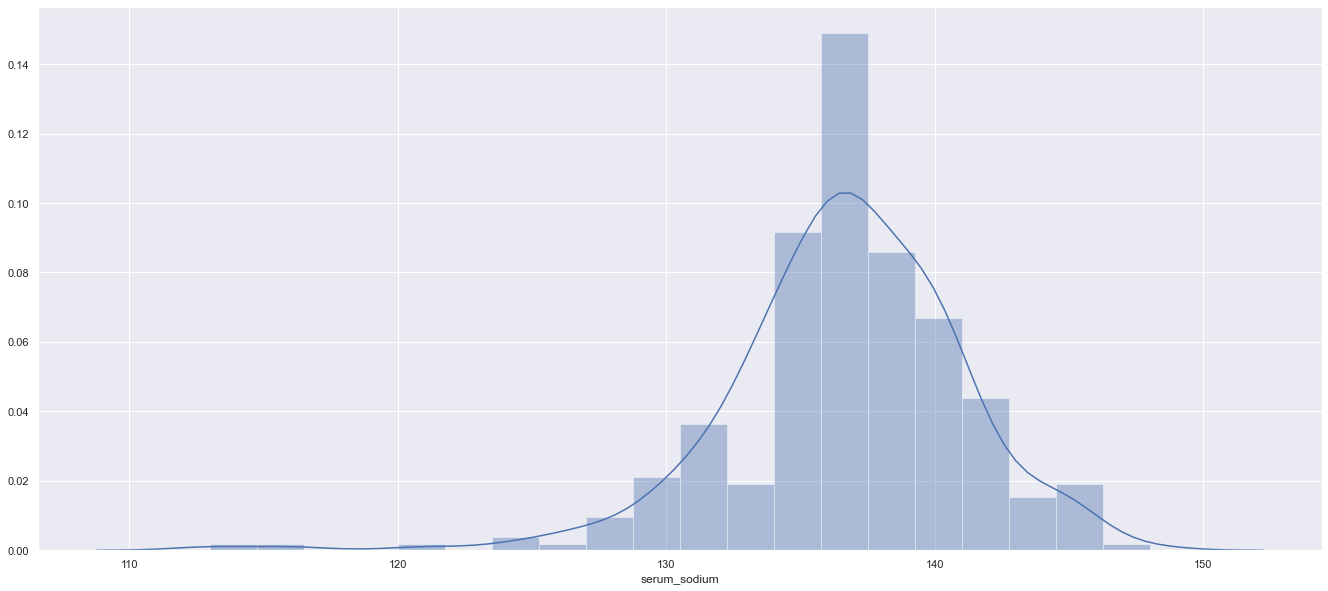

In [422]:
sns.distplot(df1['serum_sodium']);

### 1.7.2. Categorical Attributes

# 2.0. STEP 02 - FEATURE ENGINNERING

In [13]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

In [14]:
Image('img/MindMapHypothesis.png')

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

<IPython.core.display.Image object>

## 2.2. Creation of Hypotheses

### 2.2.1. Sex Hypothesis

**1.** Men are more likely to die from heart disease than women.

### 2.2.2. Smooking Hypothesis

**1.** People who smoke die more from heart failure

### 2.2.3. Diabetes Hypothesis

**1.** People with Diabetes die more from cardiac insufficiency than people without diabetes.

### 2.2.4. High Blood Pressure Hypothesis

**1.** Women with high blood pressure are more likely to die of a cardiac insufficiency than men.

### 2.2.5. Anaemia Hypothesis

**1.** People with anemia die more from cardiac insufficiency than people who do not have anemia.

## 2.3. Feature Engineering

# 3.0. STEP 03 - VARIABLES FILTERING

In [15]:
df3 = df2.copy()

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS (EDA)

In [16]:
df4 = df3.copy()

In [303]:
len(df4)

299

## 4.1. Analise Univariada

### 4.1.1. Response Variable

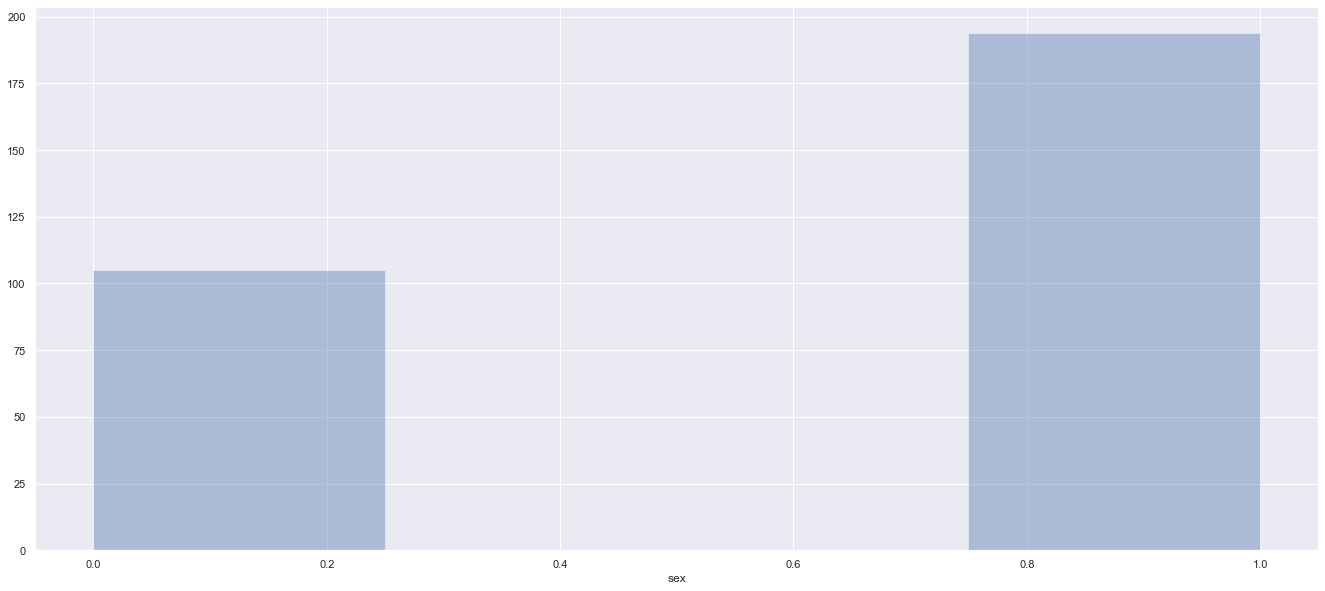

In [423]:
sns.distplot(df4['sex'], kde=False);

### 4.1.2. Numerical Variable

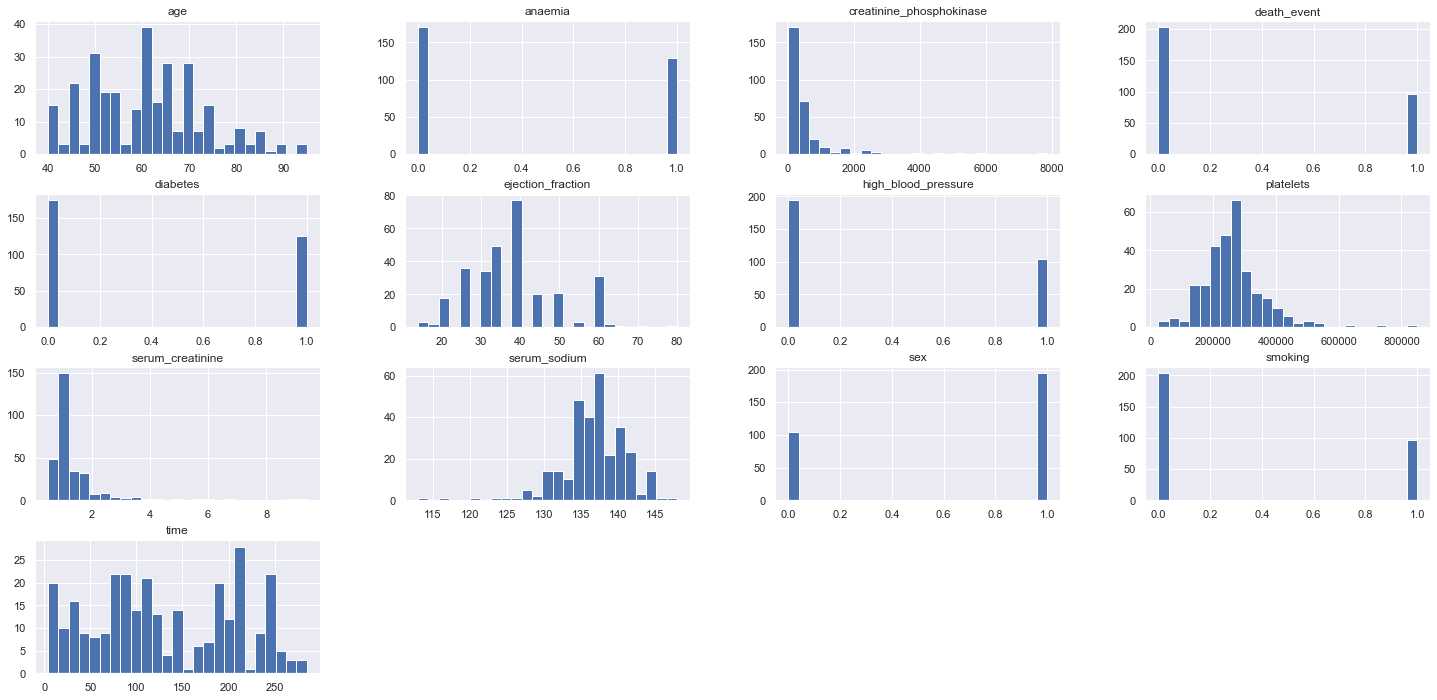

In [19]:
num_attributes.hist( bins=25);

## 4.2. Analise Bivariada

### **H1.** Men die more than women from heart failure
**False** Men die more than women from heart failure

In [461]:
aux1 = df4[(df4['death_event'] == 0)]
aux1['sex'] = aux1['sex'].apply(lambda x: 'Female' if x == 0 else 'Male')
aux2 = aux1[['sex', 'death_event']].groupby('sex').agg('count').reset_index()

aux3 = df4[(df4['death_event'] == 1)]
aux3['sex'] = aux3['sex'].apply(lambda x: 'Female' if x == 0 else 'Male')
aux4 = aux3[['sex', 'death_event']].groupby('sex').agg('count').reset_index()

In [462]:
alive_male = len(aux1[aux1['sex'] == 'Male'])
dead_male = len(aux3[aux3['sex'] == 'Male'])

alive_female = len(aux1[aux1['sex'] == 'Female'])
dead_female = len(aux3[aux3['sex'] == 'Female'])

aux5 = pd.DataFrame([alive_male,dead_male, alive_female,dead_female])

In [463]:
aux5 = pd.DataFrame(np.array(aux5).reshape(1,4), columns = ('alive_male','dead_male','alive_female','dead_female'))

In [464]:
male_soma = (aux5.loc[0][0] , aux5.loc[0][1])
male_soma = list(male_soma)
male_soma = {'Male': male_soma}
male_soma

{'Male': [132, 62]}

In [465]:
female_soma = (aux5.loc[0][2] , aux5.loc[0][3])
female_soma = list(female_soma)
female_soma = {'Female': female_soma}
female_soma

{'Female': [71, 34]}

Text(0.5, 1.0, 'Dead x Alive')

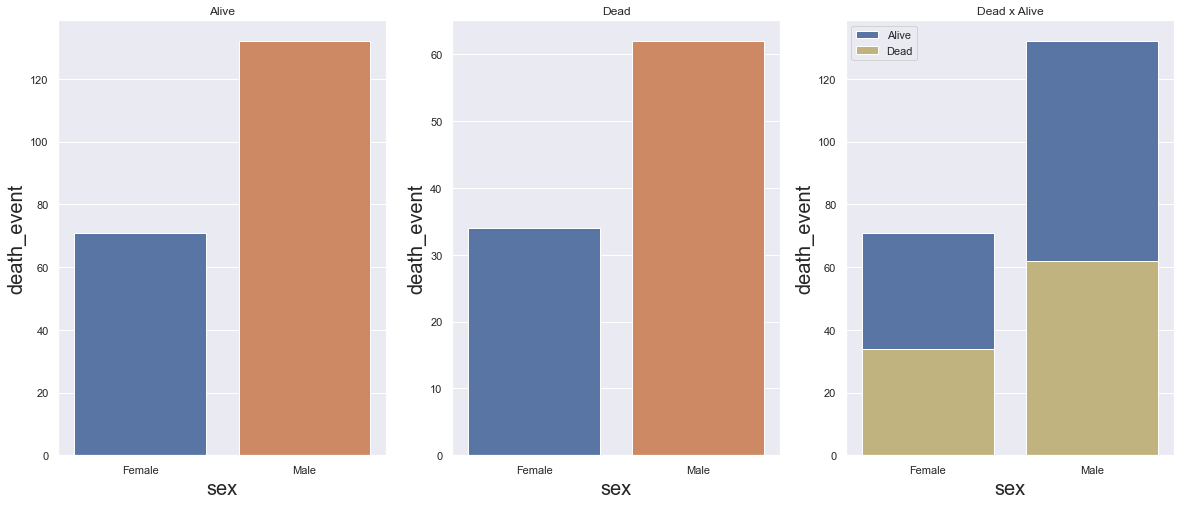

In [466]:
plt.subplot(1,3,1)
sns.barplot(x='sex', y='death_event', data=aux2)
plt.title('Alive')

plt.subplot(1,3,2)
sns.barplot(x='sex', y='death_event', data=aux4)
plt.title('Dead')

plt.subplot(1,3,3)
sns.barplot(x='sex', y='death_event', data=aux2 , label = 'Alive', color = 'b')
sns.barplot(x='sex', y='death_event', data=aux4, label = 'Dead', color = 'y')
plt.ylabel('death_event')
plt.xlabel('sex')
plt.legend()
plt.title('Dead x Alive')

<AxesSubplot:ylabel='Female'>

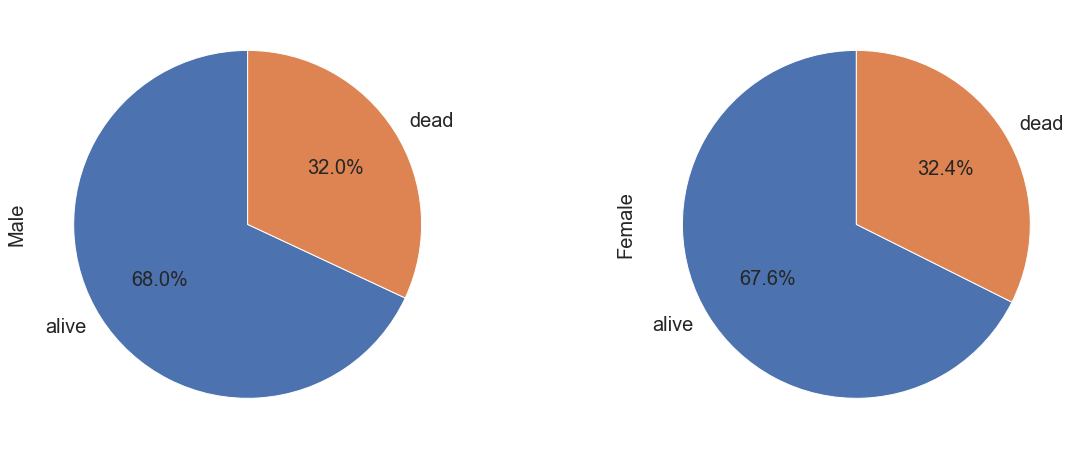

In [467]:
ax1 = plt.subplot(121, aspect='auto')
Data = male_soma
# Data = {'Male': [132,62]};
df = DataFrame(Data,columns=['Male'],index = ['alive','dead'])
plt.rc('axes', labelsize=20) 
df.plot(kind='pie', y = 'Male', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, legend = False, fontsize=20)

ax1 = plt.subplot(122, aspect='auto')
Data = female_soma
# Data = {'Female': [71,34]}
df = DataFrame(Data,columns=['Female'],index = ['alive','dead'])
plt.rc('axes', labelsize=20) 
df.plot(kind='pie', y = 'Female', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, legend = False, fontsize=20)

In [468]:
print('--------- Alive ---------')

alive_male_percentual = alive_male / 194 * 100
print('The percentage of Male alive is:   {:,.2f}%'.format(alive_male_percentual)) 

alive_female_percentual = alive_female / 105 * 100
print('The percentage of Female alive is: {:,.2f}%'.format(alive_female_percentual))

print('')
print('--------- Dead ---------')
dead_male_percentual = dead_male / 194 * 100
print('The percentage of Male dead is:   {:,.2f}%'.format(dead_male_percentual)) 

dead_female_percentual = dead_female / 105 * 100
print('The percentage of Female dead is: {:,.2f}%'.format(dead_female_percentual))

--------- Alive ---------
The percentage of Male alive is:   68.04%
The percentage of Female alive is: 67.62%

--------- Dead ---------
The percentage of Male dead is:   31.96%
The percentage of Female dead is: 32.38%


### **H2.** People who smoke die more from heart failure
**False** People who do not smoke die more from heart failure

In [487]:
aux1 = df4[(df4['death_event'] == 0)]
aux1['smoking'] = aux1['smoking'].apply(lambda x: 'non_smoking' if x == 0 else 'smoker')
aux2 = aux1[['smoking', 'death_event']].groupby('smoking').agg('count').reset_index()

aux3 = df4[(df4['death_event'] == 1)]
aux3['smoking'] = aux3['smoking'].apply(lambda x: 'non_smoking' if x == 0 else 'smoker')
aux4 = aux3[['smoking', 'death_event']].groupby('smoking').agg('count').reset_index()

In [491]:
aux4.head()

,smoking,death_event
0,non_smoking,66
1,smoker,30


In [495]:
alive_non_smoking = len(aux1[aux1['smoking'] == 'non_smoking'])
dead_non_smoking = len(aux3[aux3['smoking'] == 'non_smoking'])

alive_smoker = len(aux1[aux1['smoking'] == 'smoker'])
dead_smoker = len(aux3[aux3['smoking'] == 'smoker'])

aux5 = pd.DataFrame([alive_non_smoking,dead_non_smoking, alive_smoker, dead_smoker])

In [496]:
aux5 = pd.DataFrame(np.array(aux5).reshape(1,4), columns = ('alive_non_smoking','dead_non_smoking', 'alive_smoker', 'dead_smoker'))

In [497]:
aux5.head()

,alive_non_smoking,dead_non_smoking,alive_smoker,dead_smoker
0,137,66,66,30


In [498]:
non_smoking_soma = (aux5.loc[0][0] , aux5.loc[0][1])
non_smoking_soma = list(non_smoking_soma)
non_smoking_soma = {'non_smoking': non_smoking_soma}
non_smoking_soma

{'non_smoking': [137, 66]}

In [499]:
smoker_soma = (aux5.loc[0][2] , aux5.loc[0][3])
smoker_soma = list(smoker_soma)
smoker_soma = {'smoker': smoker_soma}
smoker_soma

{'smoker': [66, 30]}

Text(0.5, 1.0, 'Dead x Alive')

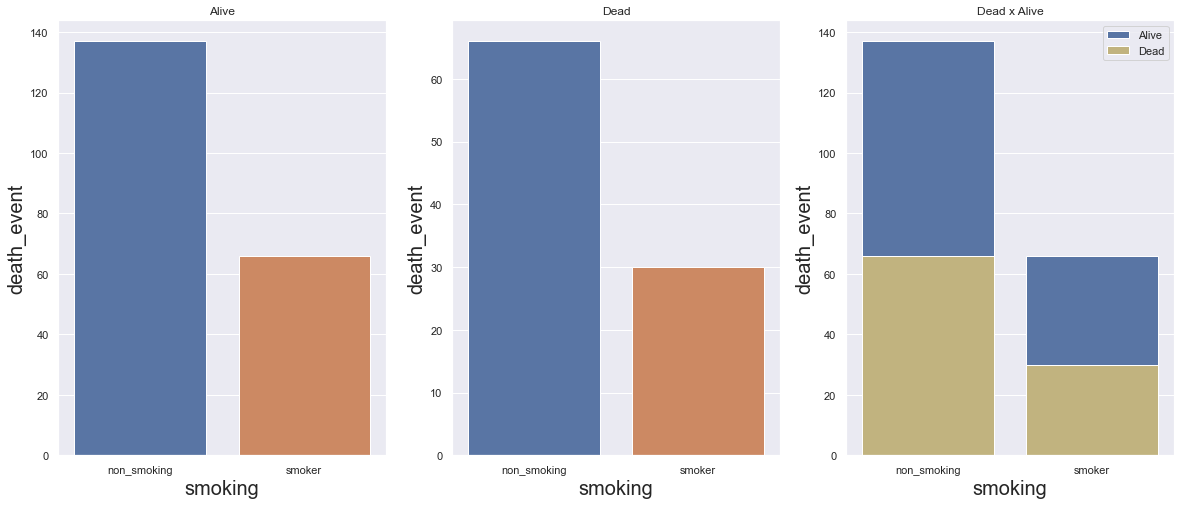

In [500]:
plt.subplot(1,3,1)
sns.barplot(x='smoking', y='death_event', data=aux2)
plt.title('Alive')

plt.subplot(1,3,2)
sns.barplot(x='smoking', y='death_event', data=aux4)
plt.title('Dead')

plt.subplot(1,3,3)
sns.barplot(x='smoking', y='death_event', data=aux2 , label = 'Alive', color = 'b')
sns.barplot(x='smoking', y='death_event', data=aux4, label = 'Dead', color = 'y')
plt.ylabel('death_event')
plt.xlabel('smoking')
plt.legend()
plt.title('Dead x Alive')

<AxesSubplot:ylabel='smoker'>

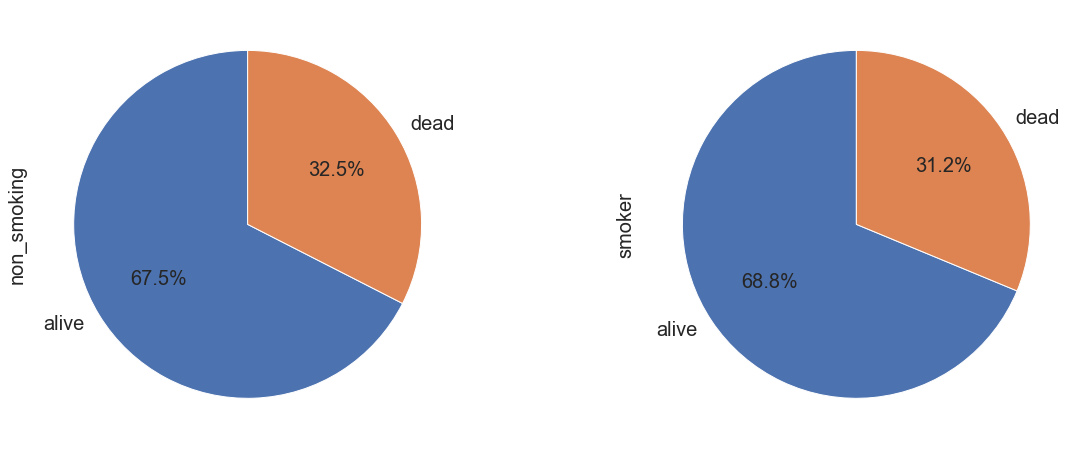

In [501]:
ax1 = plt.subplot(121, aspect='auto')
Data = non_smoking_soma
# Data = {'Male': [132,62]};
df = DataFrame(Data,columns=['non_smoking'],index = ['alive','dead'])
plt.rc('axes', labelsize=20) 
df.plot(kind='pie', y = 'non_smoking', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, legend = False, fontsize=20)

ax1 = plt.subplot(122, aspect='auto')
Data = smoker_soma
# Data = {'Female': [71,34]}
df = DataFrame(Data,columns=['smoker'],index = ['alive','dead'])
plt.rc('axes', labelsize=20) 
df.plot(kind='pie', y = 'smoker', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, legend = False, fontsize=20)

In [512]:
print('--------- Alive ---------')

alive_non_smoking_percentual = alive_non_smoking / 203 * 100
print('The percentage of non_smoking alive is: {:,.2f}%'.format(alive_non_smoking_percentual)) 

alive_smoker_percentual = alive_smoker / 96 * 100
print('The percentage of smork alive is:       {:,.2f}%'.format(alive_smoker_percentual))

print('')
print('--------- Dead ---------')
dead_non_smoking_percentual = dead_non_smoking / 203 * 100
print('The percentage of non_smoking dead is:  {:,.2f}%'.format(dead_non_smoking_percentual)) 

dead_smoker_percentual = dead_smoker / 96 * 100
print('The percentage of smoker dead is:       {:,.2f}%'.format(dead_smoker_percentual))

--------- Alive ---------
The percentage of non_smoking alive is: 67.49%
The percentage of smork alive is:       68.75%

--------- Dead ---------
The percentage of non_smoking dead is:  32.51%
The percentage of smoker dead is:       31.25%


### **H3.** 

In [441]:
print('--------- Não Depressão---------')

h_s = 0 / 2 * 100
print('O percentual de homens sem depressão é:   {:,.2f}%'.format(h_s)) 

m_s = 1 / 49 * 100
print('O percentual de mulheres sem depressão é:  {:,.2f}%'.format(m_s))

print('')
print('--------- Com Depressão ---------')
h_c = 2 / 2 * 100
print('O percentual de homens com depressão é:    {:,.2f}%'.format(h_c)) 

m_c = 48 / 49 * 100
print('O percentual de mulheres com depressão é: {:,.2f}%'.format(m_c))

print('')
print('--------- Representação de Gêneros na Pesquisa ---------')

repreh = 2 / 51 * 100
reprem = 49 / 51 * 100

print('A representação de homens na pesquisa é de {:,.2f}%, e a representação das mulheres na pesquisa é de {:,.2f}%'.format(repreh, reprem))

--------- Não Depressão---------
O percentual de homens sem depressão é:   0.00%
O percentual de mulheres sem depressão é:  2.04%

--------- Com Depressão ---------
O percentual de homens com depressão é:    100.00%
O percentual de mulheres com depressão é: 97.96%

--------- Representação de Gêneros na Pesquisa ---------
A representação de homens na pesquisa é de 3.92%, e a representação das mulheres na pesquisa é de 96.08%
